In [1]:
# import libraries
import torch
from torch import nn
from torch.nn import functional as F
import torchvision

import torchvision.transforms as transforms
#import torchvision.datasets as datasets
#from torch.utils.data import Dataset
#from torch.utils.data import DataLoader

In [1]:
import sys
from torch import nn
import torch
from datetime import timedelta
sys.path.append("../")
sys.path.append("../../")
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from open_data import open_data, create_global_batch
from dataset import RadarDataset,RadarCollate
from simple_model import LSTM
from train import train
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
PATH_CSV="/Users/clemencevast/Documents/Courses/MachineLearning/RadarTrafficData_files/Radar_Traffic_Counts.csv" #"/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv"
radar_name=' CAPITAL OF TEXAS HWY / LAKEWOOD DR'

In [3]:
df1=open_data(PATH_CSV, direction="NB", radar=radar_name, year=2018)

In [4]:
batch_df=create_global_batch(df1, window_x_day=6, window_label_day=1, gap_acquisition=1, tot_len_day=365)

Building batch 0 
 x begin 2018-01-02 label begin 2018-01-08 end period 2018-12-23 
We do not have all the dates for the time period in label , 96 94
Building batch 0 
 x begin 2018-01-03 label begin 2018-01-09 end period 2018-12-23 
We do not have all the dates for the time period in x , 576 574
Building batch 0 
 x begin 2018-01-04 label begin 2018-01-10 end period 2018-12-23 
We do not have all the dates for the time period in x , 576 574
Building batch 0 
 x begin 2018-01-05 label begin 2018-01-11 end period 2018-12-23 
We do not have all the dates for the time period in x , 576 574
Building batch 0 
 x begin 2018-01-06 label begin 2018-01-12 end period 2018-12-23 
We do not have all the dates for the time period in x , 576 574
Building batch 0 
 x begin 2018-01-07 label begin 2018-01-13 end period 2018-12-23 
We do not have all the dates for the time period in x , 576 520
Building batch 0 
 x begin 2018-01-08 label begin 2018-01-14 end period 2018-12-23 
We do not have all the dat

In [5]:
batch_df

,vol_data_x,vol_label_y
0,"[39, 24, 28, 20, 14, 14, 12, 8, 6, 7, 2, 10, 9...","[41, 37, 17, 26, 18, 17, 24, 11, 14, 7, 6, 15,..."
1,"[32, 27, 32, 25, 26, 15, 15, 18, 20, 7, 9, 15,...","[37, 34, 29, 29, 20, 15, 13, 8, 9, 14, 9, 12, ..."
2,"[63, 57, 57, 36, 32, 37, 29, 28, 13, 14, 17, 1...","[49, 33, 32, 31, 24, 20, 13, 11, 17, 8, 11, 10..."
3,"[78, 66, 45, 52, 52, 39, 40, 38, 32, 25, 17, 2...","[58, 57, 59, 39, 44, 42, 27, 29, 30, 15, 13, 1..."
4,"[35, 23, 23, 24, 14, 10, 24, 18, 9, 8, 10, 10,...","[70, 63, 36, 49, 31, 35, 24, 27, 18, 14, 20, 1..."
...,...,...
91,"[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ...","[38, 35, 29, 18, 11, 20, 11, 14, 9, 13, 6, 7, ..."
92,"[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,...","[41, 42, 32, 32, 20, 13, 22, 15, 10, 8, 5, 11,..."
93,"[70, 63, 57, 46, 38, 33, 25, 30, 24, 16, 10, 1...","[63, 52, 39, 29, 25, 17, 19, 18, 10, 8, 6, 9, ..."
94,"[87, 78, 75, 57, 45, 31, 35, 28, 26, 15, 10, 1...","[82, 87, 67, 69, 46, 32, 40, 27, 23, 19, 23, 1..."


In [7]:
#batch_df["mean_x"]=batch_df["vol_data_x"].apply(lambda x : np.mean(x))
#batch_df["std_x"]=batch_df["vol_data_x"].apply(lambda x : np.std(x))
#batch_df["mean_y"]=batch_df["vol_label_y"].apply(lambda x : np.mean(x))
# batch_df

In [6]:
def get_df_stats(df,columns=None):
    """ return mean and std for the columns"""
    if columns is None: 
        columns=["vol_data_x","vol_label_y"]
    dic={}
    global_mean=0
    global_std=0
    for name in columns:
        df["{}_min".format(name)]=df[name].apply(lambda x : np.min(x))
        df["{}_max".format(name)]=df[name].apply(lambda x : np.max(x))
        global_mean+=df["{}_min".format(name)].min()
        global_std+=df["{}_max".format(name)].max()
    return global_mean/len(columns),global_std/len(columns)
    
def apply_norm(df,mini,maxi,columns=None):
    """ apply std"""
    if columns is None: 
        columns=["vol_data_x","vol_label_y"]
    for name in columns:
        df["{}_norm".format(name)]=df[name].apply(lambda x : (x-mini)/(maxi-mini))
    return df

In [7]:
df_mean,df_std=get_df_stats(batch_df)
new_data=apply_norm(batch_df,df_mean,df_std)


In [8]:
get_df_stats(new_data,["vol_data_x_norm","vol_label_y_norm"])

(0.0, 1.0)

In [9]:
new_data

,vol_data_x,vol_label_y,vol_data_x_min,vol_data_x_max,vol_label_y_min,vol_label_y_max,vol_data_x_norm,vol_label_y_norm,vol_data_x_norm_min,vol_data_x_norm_max,vol_label_y_norm_min,vol_label_y_norm_max
0,"[39, 24, 28, 20, 14, 14, 12, 8, 6, 7, 2, 10, 9...","[41, 37, 17, 26, 18, 17, 24, 11, 14, 7, 6, 15,...",2,496,6,482,"[0.03927813163481953, 0.02335456475583864, 0.0...","[0.041401273885350316, 0.037154989384288746, 0...",0.000000,0.524416,0.004246,0.509554
1,"[32, 27, 32, 25, 26, 15, 15, 18, 20, 7, 9, 15,...","[37, 34, 29, 29, 20, 15, 13, 8, 9, 14, 9, 12, ...",3,496,4,482,"[0.03184713375796178, 0.02653927813163482, 0.0...","[0.037154989384288746, 0.03397027600849257, 0....",0.001062,0.524416,0.002123,0.509554
2,"[63, 57, 57, 36, 32, 37, 29, 28, 13, 14, 17, 1...","[49, 33, 32, 31, 24, 20, 13, 11, 17, 8, 11, 10...",3,496,6,500,"[0.06475583864118896, 0.058386411889596604, 0....","[0.049893842887473464, 0.032908704883227176, 0...",0.001062,0.524416,0.004246,0.528662
3,"[78, 66, 45, 52, 52, 39, 40, 38, 32, 25, 17, 2...","[58, 57, 59, 39, 44, 42, 27, 29, 30, 15, 13, 1...",3,500,7,434,"[0.08067940552016985, 0.06794055201698514, 0.0...","[0.059447983014861996, 0.058386411889596604, 0...",0.001062,0.528662,0.005308,0.458599
4,"[35, 23, 23, 24, 14, 10, 24, 18, 9, 8, 10, 10,...","[70, 63, 36, 49, 31, 35, 24, 27, 18, 14, 20, 1...",3,500,6,402,"[0.03503184713375796, 0.022292993630573247, 0....","[0.07218683651804671, 0.06475583864118896, 0.0...",0.001062,0.528662,0.004246,0.424628
...,...,...,...,...,...,...,...,...,...,...,...,...
91,"[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ...","[38, 35, 29, 18, 11, 20, 11, 14, 9, 13, 6, 7, ...",3,488,4,484,"[0.059447983014861996, 0.027600849256900213, 0...","[0.03821656050955414, 0.03503184713375796, 0.0...",0.001062,0.515924,0.002123,0.511677
92,"[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,...","[41, 42, 32, 32, 20, 13, 22, 15, 10, 8, 5, 11,...",3,488,5,501,"[0.050955414012738856, 0.040339702760084924, 0...","[0.041401273885350316, 0.04246284501061571, 0....",0.001062,0.515924,0.003185,0.529724
93,"[70, 63, 57, 46, 38, 33, 25, 30, 24, 16, 10, 1...","[63, 52, 39, 29, 25, 17, 19, 18, 10, 8, 6, 9, ...",3,501,6,480,"[0.07218683651804671, 0.06475583864118896, 0.0...","[0.06475583864118896, 0.05307855626326964, 0.0...",0.001062,0.529724,0.004246,0.507431
94,"[87, 78, 75, 57, 45, 31, 35, 28, 26, 15, 10, 1...","[82, 87, 67, 69, 46, 32, 40, 27, 23, 19, 23, 1...",3,501,5,409,"[0.09023354564755838, 0.08067940552016985, 0.0...","[0.08492569002123142, 0.09023354564755838, 0.0...",0.001062,0.529724,0.003185,0.432059


In [13]:
#get_df_stats(new_data,columns=["vol_data_x_norm","vol_label_y_norm"])

In [14]:
# sample_rate = 16000
batch_size = 1

In [15]:
normalize=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[df_mean],
                         std=[df_std])
])
fullset = RadarDataset(dataframe=batch_df,transform=None)

ptrain,pval,ptest=0.8,0.05,0.15
trainglobdataset, testdataset = train_test_split(fullset, test_size=ptest)
traindataset, valdataset = train_test_split(trainglobdataset, test_size=pval/(1-ptest))

<class 'dataset.RadarDataset'>
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)


In [16]:
collate_fn = RadarCollate()
trainloader = DataLoader(traindataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valloader = DataLoader(valdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
testloader = DataLoader(testdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

In [17]:
c= 0
for x in trainloader:
    print("batch number {}".format(c))
    print(x[0].shape, x[1].shape, "\n")
    #print(x)
    c+=1

batch number 0
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 1
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 2
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 3
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 4
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 5
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 6
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 7
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 8
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 9
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 10
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 11
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 12
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 13
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 14
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 15
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 16
torch.Size([1, 576]) torch.Size([1, 96]) 

batch n

## Modèle 1 

In [38]:
input_dim = 576    
hidden_dim = 256
layer_dim = 2
output_dim = 96
seq_dim = 1

lr = 0.05
n_epochs = 100
iterations_per_epoch = len(trainloader)
best_acc = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
model=LSTM()


In [39]:
iteration,loss_train_list,loss_val_list=train(model, trainloader, valloader, lr=lr, n_epochs=n_epochs, device=device,ite_print=5)

epoch 1 loss train 1.0797309187182691e-05 loss val 0.0001417884777765721
epoch 6 loss train 2.418282292637741e-06 loss val 5.496926678461023e-05
epoch 11 loss train 2.1137236672075232e-06 loss val 3.583397847251035e-05
epoch 16 loss train 3.336307230483726e-08 loss val 3.0211323974072002e-05
epoch 21 loss train 3.220711448648217e-07 loss val 3.0051154681132175e-05
epoch 26 loss train 2.927809248376434e-07 loss val 2.2653704945696518e-05
epoch 31 loss train 1.4790131785957783e-07 loss val 2.524747105780989e-05
epoch 36 loss train 1.372626684315037e-06 loss val 1.5251197510224301e-05
epoch 41 loss train 1.2414093930601666e-07 loss val 1.2627630894712638e-05
epoch 46 loss train 1.7177150084535242e-06 loss val 1.0036130333901383e-05
epoch 51 loss train 6.869262847430946e-07 loss val 7.777936843922362e-06
epoch 56 loss train 3.252537439379921e-08 loss val 6.97227460477734e-06
epoch 61 loss train 9.480582775722723e-06 loss val 6.137674063211307e-06
epoch 66 loss train 5.44728095519531e-07 lo

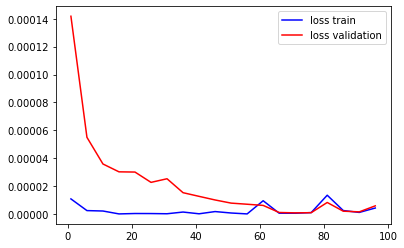

In [40]:
fig,ax=plt.subplots()
ax.plot(iteration,loss_train_list,"b",label="loss train")
ax.plot(iteration,loss_val_list,"r",label="loss validation")
ax.legend()

## Modèle 2 

In [42]:
input_dim = 576    
hidden_dim = 256
layer_dim = 2
output_dim = 96
seq_dim = 1

lr2 = 0.001
n_epochs = 100
iterations_per_epoch = len(trainloader)
best_acc = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=LSTM()


In [43]:
iteration2,loss_train_list2,loss_val_list2=train(model, trainloader, valloader, lr=lr2, n_epochs=n_epochs, device=device,ite_print=2)

epoch 1 loss train 7.951389875415771e-07 loss val 0.001313310582190752
epoch 3 loss train 9.809006769501138e-06 loss val 0.001268664957024157
epoch 5 loss train 6.490228798838871e-08 loss val 0.0012932908721268177
epoch 7 loss train 7.918869471268408e-08 loss val 0.00123077433090657
epoch 9 loss train 1.13233291187953e-07 loss val 0.001284185447730124
epoch 11 loss train 1.2977329433283558e-08 loss val 0.0012330478057265282
epoch 13 loss train 6.281256759166354e-08 loss val 0.0012403071159496903
epoch 15 loss train 2.0652284149491607e-07 loss val 0.0011579699348658323
epoch 17 loss train 9.325962935236021e-08 loss val 0.001223128056153655
epoch 19 loss train 2.312210796162617e-07 loss val 0.001244132756255567
epoch 21 loss train 2.670889500677731e-07 loss val 0.0012406371533870697
epoch 23 loss train 1.3514147667592624e-07 loss val 0.0011724295327439904
epoch 25 loss train 1.0004890782511211e-07 loss val 0.0010878320317715406
epoch 27 loss train 4.993577817913319e-07 loss val 0.0011040

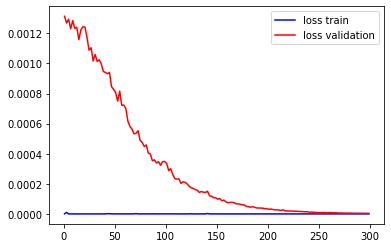

In [44]:
fig,ax=plt.subplots()
ax.plot(iteration2,loss_train_list2,"b",label="loss train")
ax.plot(iteration2,loss_val_list2,"r",label="loss validation")
ax.legend()